## Deep Learning & Image Classification Setup
### Importing Libraries 

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import sklearn
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as base_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

2025-04-18 11:49:06.824725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744976947.234774      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744976947.343069      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Paths and Directory Setup

In [2]:
images_dir = "/kaggle/input/skin-dataset/skin/HAM10000_data"
csv_path = "/kaggle/input/skin-dataset/skin/HAM10000_metadata.csv"
data_images_dir='/kaggle/working/Images'
data_images_tmp='/kaggle/working/tmp'

## Hair Removal & Image Preprocessing
### To improve model performance on dermatoscopic images, this script removes hair artifacts using OpenCV techniques before saving the cleaned images to a temporary directory.

In [3]:
def preprocess(image):
    try:
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
        _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
        gaussian = cv2.GaussianBlur(final_image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
        return final_image
    except Exception as e:
        print(f"Error in hair removal: {str(e)}")
        return image


In [4]:
input_dir = images_dir
output_dir = data_images_tmp
os.makedirs(output_dir, exist_ok=True)

images = os.listdir(input_dir)

for image_name in tqdm(images):
    input_path = os.path.join(input_dir, image_name)
    output_path = os.path.join(output_dir, image_name)

    image = cv2.imread(input_path)

    if image is None:
        print(f"Failed to read: {input_path}")
        continue

    processed = preprocess(image)

    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    Image.fromarray(processed_rgb).save(output_path)


100%|██████████| 10015/10015 [09:37<00:00, 17.35it/s]


## Organizing Images by Class Labels
### Images are organized into directories named after their diagnostic class (`dx`) for easier loading with image generators or datasets.

In [5]:

%system rm -rf $data_images_dir
%system mkdir $data_images_dir

df = pd.read_csv(csv_path)
    
for _, row in df.iterrows():
    image_id = row["image_id"] + ".jpg" 
    class_name = row["dx"]
    
    class_dir = os.path.join(data_images_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    src_path = os.path.join(data_images_tmp, image_id)
    dst_path = os.path.join(class_dir, image_id)
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("Images have been successfully organized into class directories!")

Images have been successfully organized into class directories!


## Handling Class Imbalance: Class Weights

In [6]:
class_labels = np.unique(df["dx"])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=df["dx"]
)

class_wt_dict = dict(enumerate(class_weights))
class_wt_dict_labels = dict(zip(class_labels, class_weights))

print(class_wt_dict)
print(class_wt_dict_labels)

{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}
{'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


## Image Data Augmentation 
-  Random rotation 
-  Horizontal shift 
-  Vertical shift 
-  Shear transformation
-  Random zoom
-  Random brightness adjustment
-  Small changes in RGB channels
-  Random horizontal flips
-  Fill strategy for empty pixels after transformations
-  15% of data reserved for validation

In [7]:
image_gen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               brightness_range=[0.9,1.1],
                               channel_shift_range=0.05,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.15)

## Data Generators for Training and Validation

In [8]:
batch_size = 32
target_size = (299,299)
train_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Visualizing a Sample Image from the Training Generator

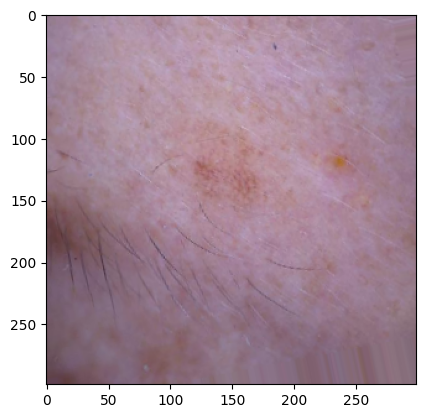

In [26]:
plt.imshow(train_image_gen[0][0][0]/255)

## Model Architecture: Transfer Learning with DenseNet201

### We leverage **DenseNet201**, a highly efficient and high-performing convolutional neural network, pretrained on ImageNet. The base is extended with a custom classification head tailored for the 7 skin lesion categories in the HAM10000 dataset.

In [32]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable=True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Summary: DenseNet201 + Custom Classifier

In [33]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 305, 305, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 75, 75, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 75, 75, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 75, 75, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 19,309,127 (73.66 MB)

 Trainable params: 19,080,071 (72.78 MB)

 Non-trainable params: 229,056 (894.75 KB)

## Model Compilation

In [34]:
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Callbacks for Efficient Training

In [35]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,mode='max', min_lr=0.00000001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce,early_stop]

## Training the Model

In [37]:
%%time
history = model.fit(train_image_gen,
                    epochs=30,
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/30
253/267 ━━━━━━━━━━━━━━━━━━━━ 10s 746ms/step - accuracy: 0.4811 - loss: 8.0805

2025-04-12 18:41:16.890892: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m6.669773587s

********************************
[Compiling module a_inference_one_step_on_data_221728__.89687] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4850 - loss: 8.0076
Epoch 1: val_accuracy improved from -inf to 0.72648, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.4852 - loss: 8.0025 - val_accuracy: 0.7265 - val_loss: 4.4571 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.6616 - loss: 4.1759
Epoch 2: val_accuracy improved from 0.72648 to 0.75450, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 240s 877ms/step - accuracy: 0.6616 - loss: 4.1748 - val_accuracy: 0.7545 - val_loss: 3.2987 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.7234 - loss: 3.1209
Epoch 3: val_accuracy did not improve from 0.75450
267/267 ━━━━━━━━━━━━━━━━━━━━ 238s 869ms/step - accuracy: 0.7233 - loss: 3.1205 - val_accuracy: 0.7218 - val_loss: 2.9045 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.7581 - loss:

## Plotting Training and Validation Loss

<Axes: >

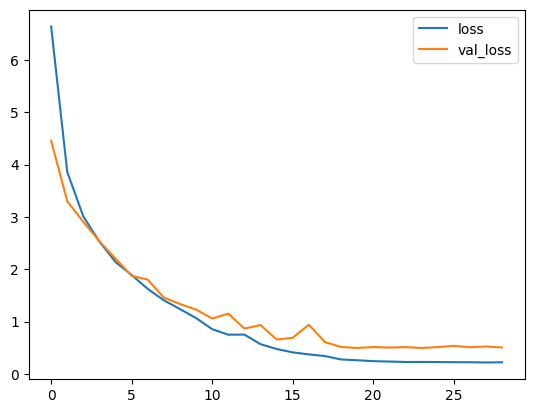

In [38]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

## Plotting Training and Validation Accuracy

<Axes: >

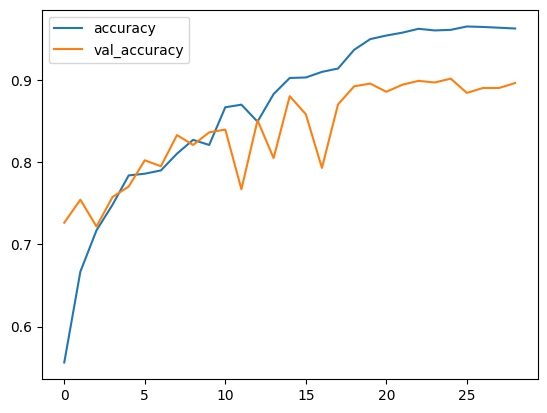

In [39]:
metrics[["accuracy","val_accuracy"]].plot()

## Model Evaluation

In [10]:
model.evaluate(test_image_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744977574.540216     114 service.cc:148] XLA service 0x7dc2a400db30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744977574.541967     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744977574.541988     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744977575.312396     114 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744977578.776787     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8412 - loss: 1.4803

E0000 00:00:1744977618.136715     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744977618.272710     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 844ms/step - accuracy: 0.8428 - loss: 1.4751


[1.3552049398422241, 0.8792528510093689]

## Making Predictions and Evaluating Model Output

In [11]:
y_score = model.predict(test_image_gen, verbose=1)
predictions = y_score.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 845ms/step


## Confusion Matrix

In [12]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[ 39   4   4   0   1   1   0]
 [  1  73   0   0   2   0   1]
 [  6   2 130   1  11  14   0]
 [  2   0   0  15   0   0   0]
 [  1   2  16   0 119  26   2]
 [  0   7  18   3  44 933   0]
 [  0   0   0   0   1   0  20]]


## Normalized Confusion Matrix

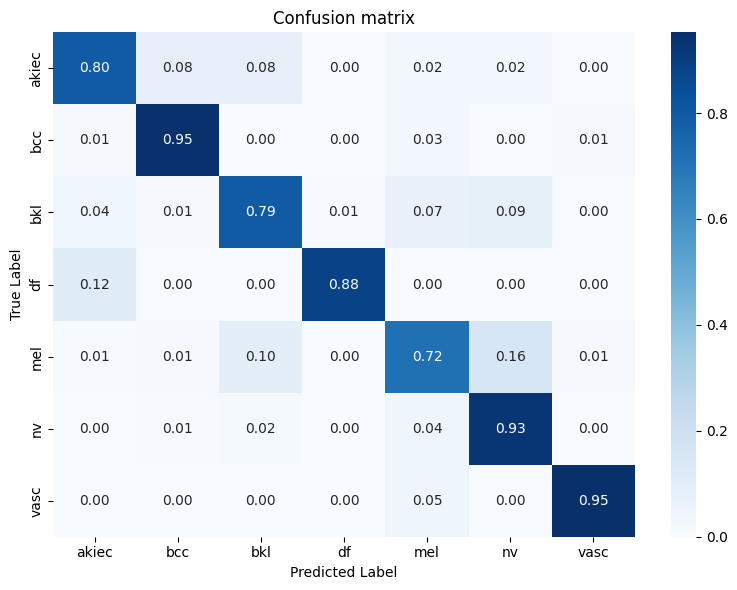

In [13]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes=list(test_image_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Classification Report

In [14]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        49
           1       0.83      0.95      0.88        77
           2       0.77      0.79      0.78       164
           3       0.79      0.88      0.83        17
           4       0.67      0.72      0.69       166
           5       0.96      0.93      0.94      1005
           6       0.87      0.95      0.91        21

    accuracy                           0.89      1499
   macro avg       0.81      0.86      0.83      1499
weighted avg       0.89      0.89      0.89      1499



## ROC AUC Score Calculation for Multi-class Classification

In [15]:
class_names = list(test_image_gen.class_indices.keys())
n_classes = len(class_names)

y_test_bin = label_binarize(test_labels, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    print(f"ROC AUC Score for Class {class_names[i]}: AUC = {roc_auc[i]:.4f}")

ROC AUC Score for Class akiec: AUC = 0.9870
ROC AUC Score for Class bcc: AUC = 0.9973
ROC AUC Score for Class bkl: AUC = 0.9745
ROC AUC Score for Class df: AUC = 0.9962
ROC AUC Score for Class mel: AUC = 0.9601
ROC AUC Score for Class nv: AUC = 0.9785
ROC AUC Score for Class vasc: AUC = 0.9995


## Plot ROC AUC  curves for all classes

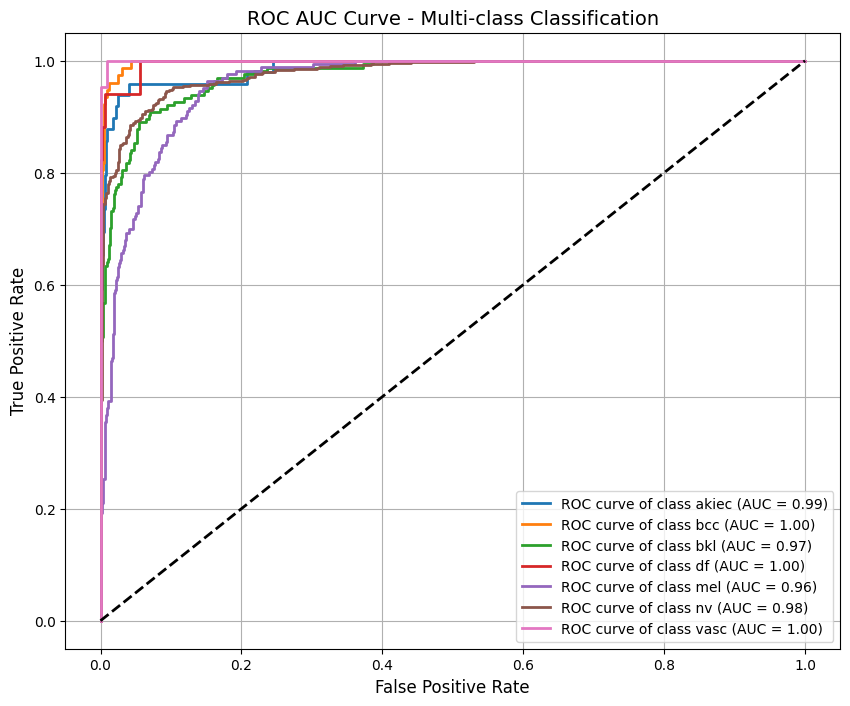

In [16]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC AUC Curve - Multi-class Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## Plot Precision-Recal curves for all classes

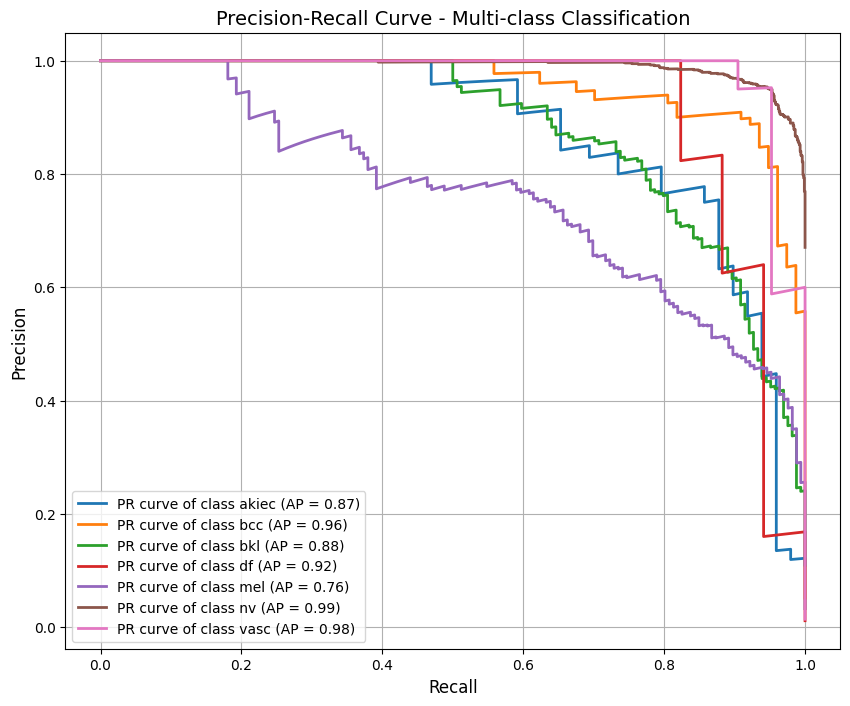

In [17]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Multi-class Classification", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()